# Topic Analysis with SpaCy
## Data Pre-processing
Import necessary packages and functions

In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import en_core_web_sm
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import gender_guesser.detector as gender
import dateutil.parser as dparser
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() #Notebook visualisation enabled


Read data and exploration

In [330]:
data=pd.read_csv('Data/speeches.csv')
data=data.drop(data.columns[0],axis=1)
data.head(10)

,Speaker,Title,Links,Delivered,Speeches
0,"Martin Luther King, Jr.",I Have A Dream,speeches/mlkihaveadream.htm,"delivered \r\n 28 August 1963, at the Lin...",I am happy to join with you today in what will...
1,John Fitzgerald Kennedy,Inaugural Address,speeches/jfkinaugural.htm,"delivered 20 January 1961, \r\nWashington, D.C.","Vice President Johnson, Mr. Speaker, Mr. Chief..."
2,Franklin Delano Roosevelt,First Inaugural Address,speeches/fdrfirstinaugural.html,Delivered 4 March 1933,"President Hoover, Mr. Chief Justice, my friend..."
3,Franklin Delano Roosevelt,Pearl Harbor Address to the Nation,speeches/fdrpearlharbor.htm,"delivered 8 \r\nDecember 1941, Washington, D.C.","Mr. Vice President, Mr. Speaker, Members of th..."
4,Barbara Charline Jordan,1976 DNC Keynote Address,speeches/barbarajordan1976dnc.html,"delivered 12 July 1976, New York, NY",Thank you ladies and gentlemen for a very warm...
5,Richard Milhous Nixon,Checkers,speeches/richardnixoncheckers.html,delivered and broadcast live on television 23 ...,"My Fellow Americans, I come before you tonight..."
6,Malcolm X,The Ballot or the B,http://americanradioworks.publicradio.org/feat...,"King Solomon Baptist Church, Detroit, Michigan...","Mr. Moderator, Rev. Cleage, brothers and sist..."
7,Ronald Wilson Reagan,Shuttle 'Challenger' Disaster Address,speeches/ronaldreaganchallenger.htm,delivered 28 January 1986,"Ladies and Gentlemen, I'd planned to speakto y..."
8,John Fitzgerald Kennedy,Houston Ministerial Association,speeches/jfkhoustonministers.html,delivered 12 September 1960 at the Rice Hotel ...,"Reverend Meza, Reverend Reck, I'm grateful for..."
9,Lyndon Baines Johnson,We Shall Overcome,speeches/lbjweshallovercome.htm,"delivered 15 March 1965, \r\nWashington, D.C.","Mr. Speaker, Mr. President, Members of the Con..."


Step 1: Assign genders to speakers using genderguesser API

In [331]:
names=[]
#Compute full name as string to get first name
data['First_Name']=data['Speaker'].fillna(0)
for i in range(0,99,1):
    name = str(data['Speaker'][i]).split()
    names.append(name)
    data['First_Name'][i]=names[i][0]

In [332]:
#Prepare gender detector
gdetect = gender.Detector()
data['Gender']=data['First_Name'].fillna(0)
#Predict genders based on name
for i in range(0,99,1):
    data['Gender'][i]=gdetect.get_gender(data['First_Name'][i])

In [333]:
#Manually check gender frequencies and correctness
males=data.query('Gender == \'male\'')['Speaker']
print(males.unique()) #All males are indeed male
females=data.query('Gender == \'female\'')['Speaker']
print(females.unique()) #All females are indeed female
others = data.query('Gender != \'male\' & Gender !=\'female\'')[['Speaker','Gender']]
print(others.Speaker.unique()) #6 mislabeled genders, manual adjustment needed
othermales=others[others['Speaker'] != 'Mary Fisher']
otherfemales=others[others['Speaker'] == 'Mary Fisher']

['Martin Luther King, Jr.' 'John Fitzgerald Kennedy'
 'Franklin Delano Roosevelt' 'Richard Milhous Nixon' 'Malcolm X'
 'Ronald Wilson Reagan' 'Lyndon Baines Johnson' 'Mario Matthew Cuomo'
 'Jesse Louis Jackson' 'Theodore Roosevelt' 'Robert Francis Kennedy'
 'Dwight David Eisenhower' 'Thomas Woodrow Wilson'
 'Clarence Seward Darrow' 'Russell H. Conwell' 'Huey Pierce Long'
 'Harry S. Truman' 'William Cuthbert Faulkner' 'Eugene Victor Debs'
 'William Jennings Bryan' 'Spiro Theodore Agnew' 'George Catlett Marshall'
 'Edward Moore Kennedy' 'Robert Marion La Follette' 'John Llewellyn Lewis'
 'Barry Morris Goldwater' 'Hubert Horatio Humphrey' 'Newton Norman Minow'
 'Henry Louis (Lou) Gehrig' 'Mario Savio' 'Gerald Rudolph Ford'
 'Cesar Estrada Chavez' 'Jimmy Earl Carter' 'William Jefferson Clinton'
 'Eliezer (Elie) Wiesel' 'Joseph N. Welch']
['Barbara Charline Jordan' 'Anna Howard Shaw' 'Hillary Rodham Clinton'
 'Dorothy Ann Willis Richards' 'Margaret Chase Smith'
 'Barbara Pierce Bush' 'Anna 

In [334]:
#Get indexes of both females and males that were marked as 'other'
adj_idx_m=[]
malesidx=[]
for name in othermales.Speaker.unique():
    adj_idx_m.append(data.index[data['Speaker']==str(name)].tolist())
flat_midx = [item for sublist in adj_idx_m for item in sublist]
flat_fidx = data.index[data['Speaker']=='Mary Fisher'].tolist()
#Replace other with respective correct gender
for entry in flat_midx:
    data['Gender'][entry]='male'
data['Gender'][flat_fidx]='female'
data['Gender']=data['Gender']
print(data['Gender'].value_counts())

male      79
female    21
Name: Gender, dtype: int64


Only 79 males and 21 females remain!

Step 2: Identify speeches given during American wars
(World War 1: 1917 - 1918, World War 2: 1941 - 1945, Korean War: 1950 - 1953, Vietnam War: 1964 - 1975, Gulf War: 1990 - 1991)

In [335]:
data['Year']=data['Delivered'].fillna(0)
for i in range(0,22,1):
    date=dparser.parse(data['Delivered'][i],fuzzy=True)
    data['Year'][i]=date.year
for i in range(24,100,1):
    date=dparser.parse(data['Delivered'][i],fuzzy=True)
    data['Year'][i]=date.year
data.iloc[22,7]=1924
data.iloc[23,7]=1912
data['Year'][data['Year']==1971]=1971
data.Year.unique()

array([1963, 1961, 1933, 1941, 1976, 1952, 1964, 1986, 1960, 1965, 1984,
       1974, 1951, 1968, 1906, 1917, 1962, 1969, 1924, 1912, 1934, 1915,
       1940, 1983, 1981, 1947, 1950, 2014, 1995, 1953, 1988, 1918, 1967,
       1900, 1990, 1992, 1948, 1937, 1966, 1916, 1991, 1919, 1939, 1970,
       1980, 1932, 1913, 1908, 1925, 1920, 1935, 1979, 1987, 1999, 1954,
       1971], dtype=object)

In [338]:
wartimes=[1917,1918]
for i in range(1941,1945,1):
    wartimes.append(i)
for i in range(1950,1953):
    wartimes.append(i)
for i in range(1964,1975):
    wartimes.append(i)
for i in range(1990,1991):
    wartimes.append(i)
data['War']=data['Year'].fillna(0)
for i in range(0,100,1):
    if data['Year'][i] in wartimes:
        data['War'][i]='Yes'
    else:
        data['War'][i]='No'
data.War.value_counts()

C:\Users\Kylan\AppData\Local\Temp\ipykernel_15384\3984470095.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['War'][i]='No'


No     62
Yes    38
Name: War, dtype: int64

In total, we have 62 non-wartime speeches and 38 speeches delivered during wartime

Step 3: Tokenization and text cleanup

In [101]:
scripts=data['Speeches'] #Get webscraped data
scripts.head()

0    I am happy to join with you today in what will...
1    Vice President Johnson, Mr. Speaker, Mr. Chief...
2    President Hoover, Mr. Chief Justice, my friend...
3    Mr. Vice President, Mr. Speaker, Members of th...
4    Thank you ladies and gentlemen for a very warm...
Name: Speeches, dtype: object

In [102]:
#Load SpaCy English Model
nlp = en_core_web_sm.load()

#Tags to remove
extags = ['PRON','CCONJ','PUNCT','PART','DET','ADP','NUM','SYM','SPACE']

tokens=[]
#SpaCy tokenization + lemmatization + lowercase
for speech in nlp.pipe(scripts):
    scr_tok = [token.lemma_.lower() for token in speech if token.pos_ not in extags and not token.is_stop and token.is_alpha]
    tokens.append(scr_tok)
data['tokens'] = tokens
data['tokens']


0     [happy, join, today, history, great, demonstra...
1     [vice, president, johnson, speaker, chief, jus...
2     [president, hoover, chief, justice, friend, da...
3     [vice, president, speaker, member, senate, hou...
4     [thank, lady, gentleman, warm, reception, year...
                            ...                        
95    [speaker, president, member, house, member, se...
96    [senator, mccarthy, chairman, view, request, s...
97    [president, fellow, delegate, long, meticulous...
98    [chancellor, vice, chancellor, professor, robe...
99    [thank, senator, fulbright, senator, javits, s...
Name: tokens, Length: 100, dtype: object

##  Word Cloud

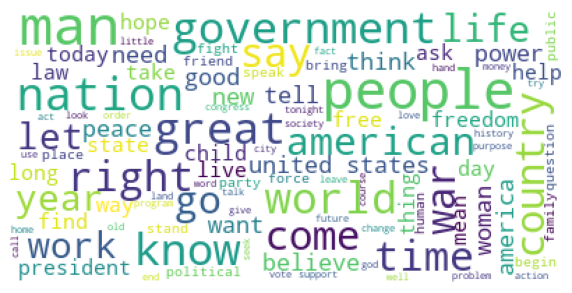

In [103]:
text = []
#Convert tokens to single string
for i in range(0,99):
    text = text + data['tokens'][i]
text = " ".join(text)
#Construct word cloud
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      max_font_size=40,
                      random_state=42).generate(text)
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off');

The word cloud gives as a nice overview of the most common tokens, which will be important when evaluating the topics later.

## LDA Topic Analysis model and coherence scores

In [104]:
dict = Dictionary(data['tokens'])
#Filter out tokens that appear in less than 5 speeches, and tokens that appear in more than 70% of speeches since they are too general. Keep the top 1000 most frequent tokens
dict.filter_extremes(no_below=5,no_above=0.5,keep_n=1000)

#Convert token counts into bag of words (BoW) corpus
corpus = [dict.doc2bow(speech) for speech in data['tokens']]

In [105]:
#Construct and train unsupervised LDA model + Determine optimal amount of topics
umtopics, umscore = [], []
cvtopics, cvscore = [], []
#Compute coherence score using C_umass:
for i in range(1,20,1):
    model = LdaMulticore(corpus=corpus, id2word=dict, iterations=50, num_topics=i, workers=4, passes=10, random_state=47)
    #LdamultiCore uses multiple cores to speed up model training, use with caution if you have a weaker PC! (Find your max number of cores with ctrl+shift+esc, under CPU)
    cm = CoherenceModel(model=model, corpus=corpus, dictionary=dict, coherence='u_mass')

    umtopics.append(i)
    umscore.append(cm.get_coherence())
#Compute coherence score using C_v: 
for i in range (1,20,1):
    model = LdaMulticore(corpus=corpus, id2word=dict, iterations=10, num_topics=i, workers = 4, passes=10, random_state=47)
    cm = CoherenceModel(model=model, texts = data['tokens'], corpus=corpus, dictionary=dict, coherence='c_v')

    cvtopics.append(i)
    cvscore.append(cm.get_coherence())
#The difference in coherence score measures is the method in which the text is segmented and probability is calculated


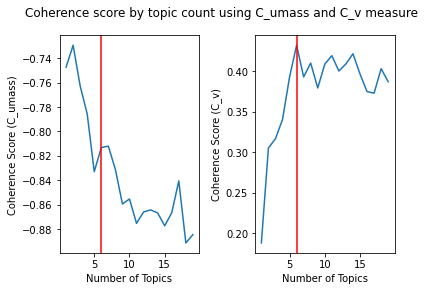

In [108]:
#Adjustable threshold for visualising with red vertical lines
threshold=6
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Coherence score by topic count using C_umass and C_v measure')
fig.subplots_adjust(wspace=0.4)

ax1.plot(umtopics,umscore)
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score (C_umass)')
ax1.axvline(x=threshold,c='red')

ax2.plot(cvtopics,cvscore)
ax2.set_xlabel('Number of Topics')
ax2.set_ylabel('Coherence Score (C_v)')
ax2.axvline(x=threshold,c='red')
#For both scores, higher values are better. Choice of topic count is subjective, but both scores must be taken into account.
plt.show()

Based on the coherence scores, best is usually the max. In this case we choose to select 8 topics, since it is the max value for the C_v score while also having a relatively higher C_umass score.

In [109]:
#Construct final model with 6 topics (Increase iterations and passes because it is the final model)
finalmodel = LdaMulticore(corpus=corpus, id2word=dict, iterations=100, num_topics=6, workers = 4, passes=100, random_state=47)

finalmodel.print_topics()

[(0,
  '0.013*"communist" + 0.011*"prove" + 0.008*"member" + 0.008*"article" + 0.008*"violence" + 0.008*"union" + 0.007*"assembly" + 0.007*"senator" + 0.007*"nations" + 0.006*"committee"'),
 (1,
  '0.017*"labor" + 0.012*"business" + 0.011*"wealth" + 0.011*"industry" + 0.010*"worker" + 0.008*"property" + 0.008*"program" + 0.008*"social" + 0.008*"pay" + 0.008*"dollar"'),
 (2,
  '0.031*"white" + 0.028*"black" + 0.026*"get" + 0.016*"vote" + 0.014*"money" + 0.011*"revolution" + 0.011*"sit" + 0.010*"poor" + 0.010*"community" + 0.009*"stop"'),
 (3,
  '0.010*"city" + 0.009*"dream" + 0.007*"faith" + 0.007*"win" + 0.007*"tonight" + 0.006*"lose" + 0.005*"struggle" + 0.005*"leadership" + 0.005*"value" + 0.005*"generation"'),
 (4,
  '0.017*"congress" + 0.010*"constitution" + 0.009*"church" + 0.008*"duty" + 0.008*"religious" + 0.008*"vote" + 0.007*"republican" + 0.007*"policy" + 0.007*"republic" + 0.006*"constitutional"'),
 (5,
  '0.021*"vietnam" + 0.012*"south" + 0.011*"military" + 0.009*"effort" +

From the words that make up each topic, we can discern the following overarching terms:  
(index 0) Topic 1: Political/Anti-communism  
(index 1) Topic 2: Economy/Worker's rights  
(index 2) Topic 3: Apartheid/Slavery  
(index 3) Topic 4: Motivational/Future/Popularity(?)  
(index 4) Topic 5: Voting Campaign/Religious  
(index 5) Topic 6: Vietnam War  

In [341]:
#Checking for first speech - MLK: I have a dream
finalmodel[corpus][0]
#Main topics are apartheid/slavery and popularity/Motivational meaning it checks out!

[(2, 0.43528447), (3, 0.561823)]

What follows is an advanced visualisation of the topics. Each circle represents a topic and upon hovering over a circle, the bars on the right illustrate the frequency of words that appear in the topic. Closer circles are more related, which is logical since political arguments correlate highly with voting campaigns. Visualisation of circles is done through PCA dimension reduction.

In [344]:
lda_display = pyLDAvis.gensim_models.prepare(finalmodel, corpus, dict)
pyLDAvis.display(lda_display)

c:\Users\Kylan\anaconda3\envs\MDA_Speech\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Compute main and secondary topics for each speech

In [366]:
data['Topic1'] = [sorted(finalmodel[corpus][text])[0][0] for text in range (len(data['Speeches']))]
for text in range (len(data['Speeches'])):
    if len(finalmodel[corpus][text])>1:
        data['Topic2'][text] = sorted(finalmodel[corpus][text])[1][0]
data.head()

C:\Users\Kylan\AppData\Local\Temp\ipykernel_15384\2397297724.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Topic2'][text] = sorted(finalmodel[corpus][text])[1][0]


,Speaker,Title,Links,Delivered,Speeches,First_Name,Gender,Year,War,Topic1,Topic2
0,"Martin Luther King, Jr.",I Have A Dream,speeches/mlkihaveadream.htm,"delivered \r\n 28 August 1963, at the Lin...",I am happy to join with you today in what will...,Martin,male,1963,No,2,3
1,John Fitzgerald Kennedy,Inaugural Address,speeches/jfkinaugural.htm,"delivered 20 January 1961, \r\nWashington, D.C.","Vice President Johnson, Mr. Speaker, Mr. Chief...",John,male,1961,No,3,4
2,Franklin Delano Roosevelt,First Inaugural Address,speeches/fdrfirstinaugural.html,Delivered 4 March 1933,"President Hoover, Mr. Chief Justice, my friend...",Franklin,male,1933,No,1,3
3,Franklin Delano Roosevelt,Pearl Harbor Address to the Nation,speeches/fdrpearlharbor.htm,"delivered 8 \r\nDecember 1941, Washington, D.C.","Mr. Vice President, Mr. Speaker, Members of th...",Franklin,male,1941,Yes,4,5
4,Barbara Charline Jordan,1976 DNC Keynote Address,speeches/barbarajordan1976dnc.html,"delivered 12 July 1976, New York, NY",Thank you ladies and gentlemen for a very warm...,Barbara,female,1976,No,3,4


In [433]:
mainoverall=data.Topic1.value_counts()
secoverall=data.Topic2.value_counts()
print('Frequency of main overall topic:'+ '\n' + 'Index   Frequency' + '\n' + str(mainoverall))
print('Frequency of secondary overall topic:' + '\n' + 'Index   Frequency' + '\n' + str(secoverall))

Frequency of main overall topic:
Index   Frequency
0    42
1    26
2    17
3     9
4     3
5     3
Name: Topic1, dtype: int64
Frequency of secondary overall topic:
Index   Frequency
3    29
2    28
1    17
5     9
4     6
Name: Topic2, dtype: int64


The overall most used topic is Topic 1: Politics/Anti-Communism, while the second-most popular overall is Topic 4: Popularity/Motivational

## Differences in Topic usage

Male vs Female

In [416]:
mainmale=data[data['Gender']=='male'].Topic1.value_counts()
mainfemale=data[data['Gender']=='female'].Topic1.value_counts()
secmale=data[data['Gender']=='male'].Topic2.value_counts()
secfemale=data[data['Gender']=='female'].Topic2.value_counts()
print('Frequency of main male topic:'+ '\n' + 'Index   Frequency' + '\n' + str(mainmale))
print('Frequency of secondary male topic:' + '\n' + 'Index   Frequency' + '\n' + str(secmale))
print('Frequency of main female topic:'+ '\n' + 'Index   Frequency' + '\n' + str(mainfemale))
print('Frequency of secondary female topic:' + '\n' + 'Index   Frequency' + '\n' + str(secfemale))

Frequency of main male topic:
Index   Frequency
0    31
1    24
2    10
3     8
4     3
5     3
Name: Topic1, dtype: int64
Frequency of secondary male topic:
Index   Frequency
2    24
3    22
1    11
5     9
4     4
Name: Topic2, dtype: int64
Frequency of main female topic:
Index   Frequency
0    11
2     7
1     2
3     1
Name: Topic1, dtype: int64
Frequency of secondary female topic:
Index   Frequency
3    7
1    6
2    4
4    2
Name: Topic2, dtype: int64


In terms of main topics, male speakers talk more about Topic 2: Economy/Worker's Rights than Topic 3: Apartheid/slavery. With female speakers, this is the other way around.  
The most important secondary topics for male speakers are Slavery and Popularising/Motivational, while for females this is Popularity and Politics.  
  
In general, we can state that the most popular speeches delivered by female speakers are more concerned with tackling humanitarian issues, as opposed to economical/pragmatic issues that are more common with the popular male speakers. However, female speakers invest a lot more of their speech into popularising themselves.

Wartime vs Peace

In [417]:
mainwar=data[data['War']=='Yes'].Topic1.value_counts()
mainpeace=data[data['War']=='No'].Topic1.value_counts()
secwar=data[data['War']=='Yes'].Topic2.value_counts()
secpeace=data[data['War']=='No'].Topic2.value_counts()
print('Frequency of main Wartime topic:'+ '\n' + 'Index   Frequency' + '\n' + str(mainwar))
print('Frequency of secondary Wartime topic:' + '\n' + 'Index   Frequency' + '\n' + str(secwar))
print('Frequency of main Peace topic:'+ '\n' + 'Index   Frequency' + '\n' + str(mainpeace))
print('Frequency of secondary Peace topic:' + '\n' + 'Index   Frequency' + '\n' + str(secpeace))

Frequency of main Wartime topic:
Index   Frequency
0    18
2     7
1     5
5     3
3     3
4     2
Name: Topic1, dtype: int64
Frequency of secondary Wartime topic:
Index   Frequency
3    11
1     9
2     7
5     4
4     2
Name: Topic2, dtype: int64
Frequency of main Peace topic:
Index   Frequency
0    24
1    21
2    10
3     6
4     1
Name: Topic1, dtype: int64
Frequency of secondary Peace topic:
Index   Frequency
2    21
3    18
1     8
5     5
4     4
Name: Topic2, dtype: int64


As expected, Topic 6: Vietnam War is only considered as a main topic during wartime. In peace, it is only used as a secondary topic, probably as comparison. Another interesting observation is that considering secondary topics, speakers tend to bring more motivational/popularising speeches during wartime, as opposed to more state-of-affairs/humanitarian oriented speeches which are given during times of peace.

In [443]:
mainoverall=mainoverall.sort_index()
def fixindices(valuecount):
    for i in mainoverall.index:
        if i not in valuecount.index:
            valuecount[i]=0
    valuecount=valuecount.sort_index()
for vc in [secoverall,mainmale,secmale,mainfemale,secfemale,mainwar,secwar,mainpeace,secpeace]:
    fixindices(vc)


C:\Users\Kylan\AppData\Local\Temp\ipykernel_15384\317517306.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0,'Politics','Economic','Apartheid','Popularity','Campaigning','War'])
C:\Users\Kylan\AppData\Local\Temp\ipykernel_15384\317517306.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([0,'Politics','Economic','Apartheid','Popularity','Campaigning','War'])


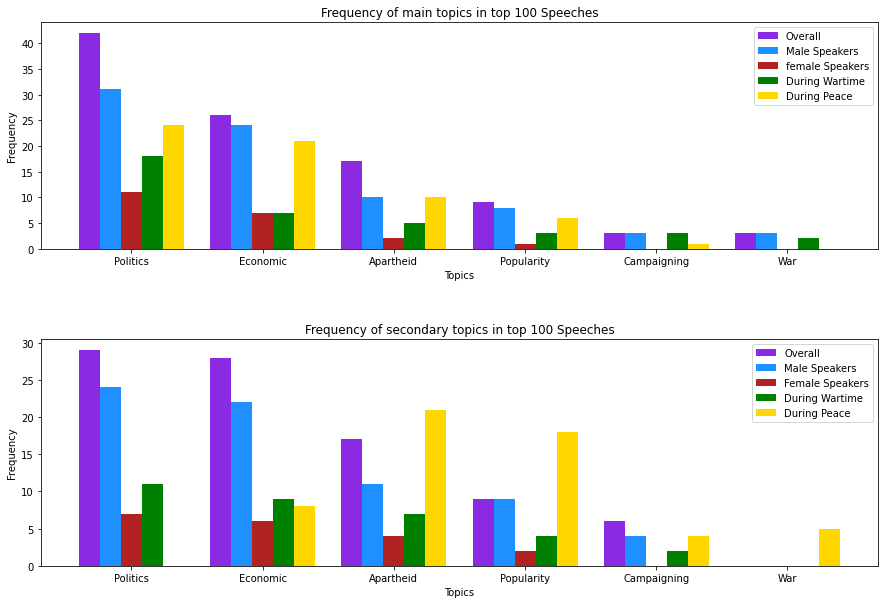

In [484]:
X = np.arange(6)
fig,(ax1,ax2) = plt.subplots(2,figsize=(15,10))
fig.subplots_adjust(hspace=0.4)
ax1.bar(X - 0.32, mainoverall, color = 'blueviolet', width = 0.16)
ax1.bar(X - 0.16, mainmale, color = 'dodgerblue', width = 0.16)
ax1.bar(X + 0.00, mainfemale, color = 'firebrick', width = 0.16)
ax1.bar(X + 0.16, mainwar, color = 'green', width = 0.16)
ax1.bar(X + 0.32, mainpeace, color = 'gold', width = 0.16)
ax1.set_ylabel('Frequency')
ax1.set_xticklabels([0,'Politics','Economic','Apartheid','Popularity','Campaigning','War'])
ax1.set_xlabel('Topics')
ax1.set_title('Frequency of main topics in top 100 Speeches')
ax1.legend(labels=['Overall','Male Speakers','female Speakers','During Wartime','During Peace'])

ax2.bar(X - 0.32, secoverall, color = 'blueviolet', width = 0.16)
ax2.bar(X - 0.16, secmale, color = 'dodgerblue', width = 0.16)
ax2.bar(X + 0.00, secfemale, color = 'firebrick', width = 0.16)
ax2.bar(X + 0.16, secwar, color = 'green', width = 0.16)
ax2.bar(X + 0.32, secpeace, color = 'gold', width = 0.16)
ax2.set_ylabel('Frequency')
ax2.set_xticklabels([0,'Politics','Economic','Apartheid','Popularity','Campaigning','War'])
ax2.set_xlabel('Topics')
ax2.set_title('Frequency of secondary topics in top 100 Speeches')
ax2.legend(labels=['Overall','Male Speakers','Female Speakers','During Wartime','During Peace'])
